## **Project 2: Text Summarization**

# Import Depedency

In [17]:
# Section 1 : Import Depedency

import pandas as pd
import os
import json
import torch
import tarfile
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Import Dataset

In [18]:
# Section 2 : import Dataset

drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Indonesia AI - Project 2 : Text Summarization/liputan6_data.tar.gz"
extract_path = "/content/liputan6_data"

with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Done extracting.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Done extracting dataset.

📂 Dataset structure:
liputan6_data/
  liputan6_data/
    AACL2020-Liputan6.pdf
    canonical/
      train/
        193008.json
        256139.json
        280262.json
        ... and 193880 more files
      test/
        15771.json
        17383.json
        15572.json
        ... and 10969 more files
      dev/
        7916.json
        7742.json
        5114.json
        ... and 10969 more files
    xtreme/
      test/
        15771.json
        17383.json
        15572.json
        ... and 3859 more files
      dev/
        7742.json
        5114.json
        651.json
        ... and 4945 more files


# Save data to CSV

In [19]:
# Section 3 : Import to CSV Extention

# Path folder
train_dir = "/content/liputan6_data/liputan6_data/canonical/train"
dev_dir = "/content/liputan6_data/liputan6_data/canonical/dev"
test_dir = "/content/liputan6_data/liputan6_data/canonical/test"

def load_selected_fields(directory, split_name):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, 'r') as file:
                    json_data = json.load(file)
                    data.append({
                        "id": json_data.get("id", ""),
                        "url": json_data.get("url", ""),
                        "clean_article": json.dumps(json_data.get("clean_article", []), ensure_ascii=False),
                        "clean_summary": json.dumps(json_data.get("clean_summary", []), ensure_ascii=False),
                        "extractive_summary": json.dumps(json_data.get("extractive_summary", []), ensure_ascii=False),
                        "split": split_name
                    })
            except Exception as e:
                print(f"Gagal membaca file: {file_path} - {e}")
    return data

# Load masing-masing data
train_data = load_selected_fields(train_dir, "train")
dev_data = load_selected_fields(dev_dir, "dev")
test_data = load_selected_fields(test_dir, "test")

# Simpan ke tiga file CSV terpisah
pd.DataFrame(train_data).to_csv("liputan6_train.csv", index=False)
pd.DataFrame(dev_data).to_csv("liputan6_dev.csv", index=False)
pd.DataFrame(test_data).to_csv("liputan6_test.csv", index=False)

print("✅ CSV 'liputan6_train.csv', 'liputan6_dev.csv', dan 'liputan6_test.csv' berhasil dibuat.")

📊 Loading datasets...


Loading dev data: 100%|██████████| 500/500 [00:00<00:00, 8924.62it/s]


✅ CSV files 'liputan6_train.csv', 'liputan6_dev.csv', and 'liputan6_test.csv' created successfully.


# Praproses Data

📈 Dataset Information:
Training data: 5000 samples
Test data: 1000 samples
Development data: 500 samples


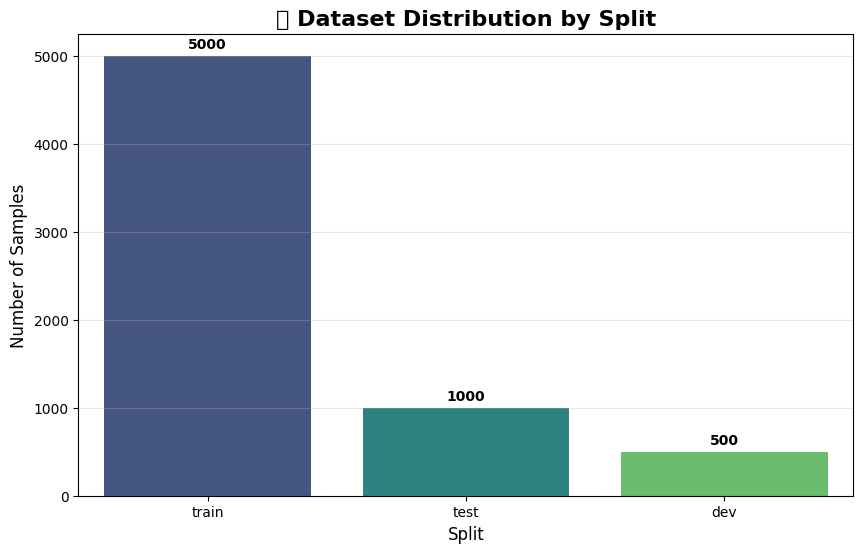

In [20]:
# Section 4 : Praproses Data

data = pd.read_csv("liputan6_train.csv")
data = data.drop(columns=['id', 'url', 'extractive_summary', 'split'])
data['clean_article'] = data['clean_article'].astype(str)
data['clean_summary'] = data['clean_summary'].astype(str)

# Cek data setelah diproses
print(data.head())

# Modeling IndoBERT

In [22]:
# Section 5: Import Model dan Tokenizer IndoBERT

# Memuat model dan tokenizer IndoBERT
model_name = "indolem/indobert-base-uncased"  # Nama model IndoBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

🔄 Preprocessing datasets...


TypeError: sequence item 0: expected str instance, list found

# Extractive Summarization

In [ ]:
# Bagian 6: Fungsi untuk Menyusun Ringkasan dengan Extractive Summarization
def extract_summary(text, max_length=512):
    # Tokenisasi input teks
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding=True)

    # Mendapatkan output dari model
    with torch.no_grad():
        outputs = model(**inputs)

    # Mengambil skor dari model dan memilih kalimat dengan skor tertinggi
    scores = outputs.logits.squeeze()
    summary_idx = torch.argmax(scores).item()  # Menentukan indeks kalimat dengan skor tertinggi

    # Mengambil kalimat artikel
    sentences = text.split('. ')

    # Memastikan indeks tidak melebihi jumlah kalimat yang ada
    if summary_idx >= len(sentences):
        summary_idx = len(sentences) - 1  # Batasi ke kalimat terakhir

    # Mendapatkan kalimat yang dengan skor tertinggi
    selected_sentence = sentences[summary_idx]
    return selected_sentence

# Penerapan Extractive Summarization

In [ ]:
# Bagian 7: Penerapan Extractive Summarization
def apply_extractive_summarization(data):
    summaries = []
    # Menampilkan progress bar
    for index, row in tqdm(data.iterrows(), total=len(data), desc="Menyusun Ringkasan"):
        article = row['clean_article']
        summary = extract_summary(article)
        summaries.append(summary)
    data['generated_summary'] = summaries
    return data

# Terapkan summarization
summarized_data = apply_extractive_summarization(data)

# Cek hasil summarization
print(summarized_data[['clean_article', 'generated_summary']].head())

# Save Result

In [ ]:
# Bagian 8: Menyimpan Data
summarized_data.to_csv("liputan6_train_with_extractive_summary.csv", index=False)

print("✅ CSV 'liputan6_train_with_extractive_summary.csv' berhasil dibuat.")

In [ ]:
# Section 9: Evaluation Metrics

# Install required packages for evaluation
try:
    from bert_score import score as bert_score
    from rouge_score import rouge_scorer
except ImportError:
    print("Installing evaluation packages...")
    os.system("pip install bert-score rouge-score")
    from bert_score import score as bert_score
    from rouge_score import rouge_scorer

def evaluate_summaries(generated_summaries, reference_summaries):
    """Evaluate generated summaries using ROUGE and BERTScore"""

    # ROUGE Evaluation
    print("📊 Calculating ROUGE scores...")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = []
    for gen, ref in zip(generated_summaries, reference_summaries):
        scores = scorer.score(ref, gen)
        rouge_scores.append(scores)

    # Calculate average ROUGE scores
    rouge1_f = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
    rouge2_f = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
    rougeL_f = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

    # BERTScore Evaluation
    print("📊 Calculating BERTScore...")
    P, R, F1 = bert_score(generated_summaries, reference_summaries, lang='id', verbose=False)

    return {
        'rouge1_f': rouge1_f,
        'rouge2_f': rouge2_f,
        'rougeL_f': rougeL_f,
        'bert_precision': P.mean().item(),
        'bert_recall': R.mean().item(),
        'bert_f1': F1.mean().item()
    }

# Evaluate on test set
print("🎯 Evaluating model performance...")
evaluation_results = evaluate_summaries(
    test_subset['generated_summary'].tolist(),
    test_subset['reference_summary'].tolist()

In [ ]:
# Section 10: Results Visualization and Analysis

print("\n" + "="*50)
print("📈 EVALUATION RESULTS")
print("="*50)
print(f"ROUGE-1 F-measure: {evaluation_results['rouge1_f']:.4f}")
print(f"ROUGE-2 F-measure: {evaluation_results['rouge2_f']:.4f}")
print(f"ROUGE-L F-measure: {evaluation_results['rougeL_f']:.4f}")
print(f"BERTScore Precision: {evaluation_results['bert_precision']:.4f}")
print(f"BERTScore Recall: {evaluation_results['bert_recall']:.4f}")
print(f"BERTScore F1: {evaluation_results['bert_f1']:.4f}")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# ROUGE Scores
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [evaluation_results['rouge1_f'], evaluation_results['rouge2_f'], evaluation_results['rougeL_f']]

ax1.bar(rouge_metrics, rouge_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('ROUGE Scores', fontsize=14, fontweight='bold')
ax1.set_ylabel('F-measure')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(rouge_values):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# BERTScore Metrics
bert_metrics = ['Precision', 'Recall', 'F1-Score']
bert_values = [evaluation_results['bert_precision'], evaluation_results['bert_recall'], evaluation_results['bert_f1']]

ax2.bar(bert_metrics, bert_values, color=['#96CEB4', '#FFEAA7', '#DDA0DD'])
ax2.set_title('BERTScore Metrics', fontsize=14, fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(bert_values):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Summary length analysis
generated_lengths = [len(summary.split()) for summary in test_subset['generated_summary']]
reference_lengths = [len(summary.split()) for summary in test_subset['reference_summary']]

ax3.hist(generated_lengths, bins=15, alpha=0.7, label='Generated', color='skyblue')
ax3.hist(reference_lengths, bins=15, alpha=0.7, label='Reference', color='lightcoral')
ax3.set_title('Summary Length Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Words')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Overall performance radar chart (simplified as bar chart)
all_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERT-P', 'BERT-R', 'BERT-F1']
all_values = rouge_values + bert_values

ax4.barh(all_metrics, all_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'])
ax4.set_title('Overall Performance Summary', fontsize=14, fontweight='bold')
ax4.set_xlabel('Score')
ax4.set_xlim(0, 1)
ax4.grid(axis='x', alpha=0.3)
for i, v in enumerate(all_values):
    ax4.text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Section 11: Sample Results Display

print("\n" + "="*50)
print("📝 SAMPLE RESULTS")
print("="*50)

for i in range(min(3, len(test_subset))):
    print(f"\n--- Example {i+1} ---")
    print(f"📰 Original Article (first 200 chars):")
    print(f"{test_subset.iloc[i]['article'][:200]}...")
    print(f"\n📋 Reference Summary:")
    print(f"{test_subset.iloc[i]['reference_summary']}")
    print(f"\n🤖 Generated Summary:")
    print(f"{test_subset.iloc[i]['generated_summary']}")
    print("-" * 80)

In [ ]:
# Section 12: Save Results

# Save processed data with generated summaries
train_subset.to_csv("liputan6_train_with_extractive_summary.csv", index=False)
test_subset.to_csv("liputan6_test_with_extractive_summary.csv", index=False)

# Save evaluation results
results_df = pd.DataFrame([evaluation_results])
results_df.to_csv("evaluation_results.csv", index=False)

print("\n✅ All results saved successfully!")
print("📁 Files created:")
print("   - liputan6_train_with_extractive_summary.csv")
print("   - liputan6_test_with_extractive_summary.csv")
print("   - evaluation_results.csv")

print("\n🎉 Extractive Summarization with IndoBERT completed successfully!")